# fMRI tutorial, subject-level encoding models (beginner level)
__Content creator:__ Florent Meyniel (NeuroSpin, CEA Paris-Saclay/Inserm; Institute for NeuroModulation, GHU Ste Anne Hospital, Paris)

This notebook contains a few examples used in the course.

In [1]:
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from nilearn.glm.first_level import run_glm
from nilearn.glm import compute_contrast
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

# Set up custom functions

This function simulates (noisy) fMRI recording in a simple task with two tones that alternate in a sequence.

In [2]:
def simulate_bold_response(SOA, evoked_response, noise, weights=None, ar_noise=0.5):
    """
    Simulates the BOLD (Blood Oxygen Level Dependent) response for a given set of stimuli.

    Parameters:
    ----------
    SOA : float
        The stimulus onset asynchrony, which determines the timing of stimulus presentation.
    evoked_response : list
        An list representing the expected response to each stimulus tone.
    noise : float
        The level of noise to be added to the simulated signal.
    weights : list, optional
        A list of weights specifying the weight of each the expected response to each stimulus onto
        the fMRI signal. The default is uniform (1s)
    ar_noise : float, optional
        The autocorrelation level for the noise (default is 0.5).

    Returns:
    -------
    events : DataFrame
        A DataFrame containing the onset, trial type, duration, and modulation of each stimulus event.
    dmtx : DataFrame
        The design matrix used for the first-level analysis, representing the expected BOLD response.
    signal : DataFrame
        A DataFrame containing the raw and noisy simulated fMRI signal.
    """

    # parameters
    TR = 1.5
    nscans = 80
    frame_times = np.cumsum([0]+[TR]*(nscans-1))

    # create a random sequence of two tones
    n_stim = len(evoked_response)*5
    events = pd.DataFrame(
        {'onset': np.cumsum([SOA]*n_stim),
         'trial_type': [f"tone_{id}" for id in range(len(evoked_response))]*5,
         'duration': [0.01]*n_stim,
         'modulation': evoked_response*5})

    # Forward model: compute response elicted by
    # those tones
    if weights is None:
        weights = np.ones(len(evoked_response))
    dmtx = make_first_level_design_matrix(
        frame_times,
        events=pd.DataFrame(events),
        hrf_model='spm',
        drift_model=None)

    # simulate uncorrupted fMRI signal as the effect of the tones
    signal = pd.DataFrame()
    signal.index = frame_times
    signal['raw'] = np.sum([w*dmtx[f"tone_{k}"].values for (k, w) in enumerate(weights)], axis=0)
    # scaling_factor = signal['raw'].mean()
    # signal['raw'] /= scaling_factor
    # dmtx /= scaling_factor

    # corrupt signal with autocorrelated noise
    ma = np.array([1])  # unit moving average
    ar1 = np.array([1, -ar_noise])  # level of AR1 correlation
    arma_process = ArmaProcess(ar1, ma)
    signal['noisy'] = signal['raw'] + noise*arma_process.generate_sample(nscans)

    return events, dmtx, signal

set up the random generator seed to make the results reproducible

In [3]:
np.random.seed(1)

# Linear regression: The code behind some figures of the slides

## Visualize the correlation between two time-series with an X/Y scatter plot

[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


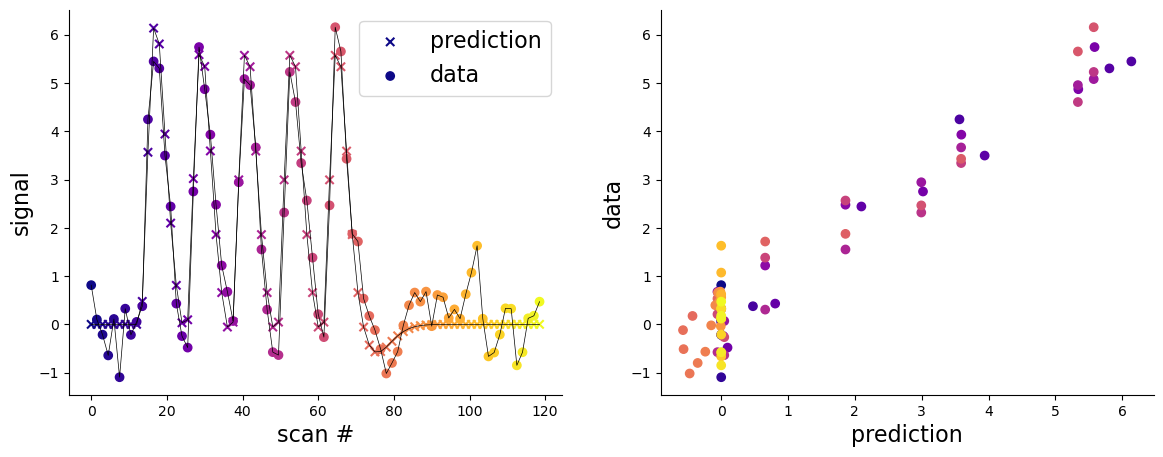

In [4]:
_, _, simulated_signal = simulate_bold_response(SOA=12, evoked_response=[1000], noise=0.5)

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# get number of points
n_points = len(simulated_signal)

# Create HSV color gradient without transparency
hsv_colormap = plt.cm.plasma
color_indices = np.linspace(0, 1, n_points)
colors = hsv_colormap(color_indices)

ax1.scatter(simulated_signal.index, simulated_signal['raw'], color=colors, marker='x', label='prediction')
ax1.scatter(simulated_signal.index, simulated_signal['noisy'], color=colors, marker='o', label='data')
ax1.plot(simulated_signal.index, simulated_signal['raw'], color='black', linewidth=0.5)
ax1.plot(simulated_signal.index, simulated_signal['noisy'], color='black', linewidth=0.5)
ax1.set_xlabel('scan #', fontsize=16)
ax1.set_ylabel('signal', fontsize=16)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(fontsize=16)

ax2.scatter(simulated_signal['raw'], simulated_signal['noisy'], color=colors)
ax2.set_xlabel('prediction', fontsize=16)
ax2.set_ylabel('data', fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig.savefig('simulated_signal.svg')

## Linear regression in one dimension

An example with a true effect

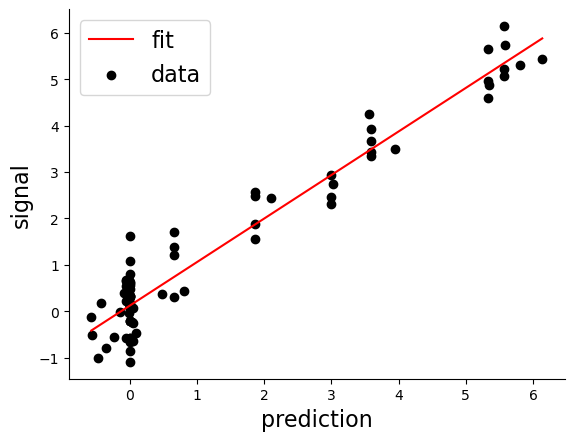

In [5]:
reg = LinearRegression().fit(simulated_signal['raw'].values.reshape([-1, 1]), simulated_signal['noisy'])
pred_range = np.array([min(simulated_signal['raw']), max(simulated_signal['raw'])])
fit_range = reg.predict(pred_range.reshape(-1, 1)).reshape(-1, 1)

fig, ax = plt.subplots()
ax.plot(pred_range, fit_range, 'r-', label='fit')
ax.scatter(simulated_signal['raw'], simulated_signal['noisy'], color='k', label='data')
ax.legend(fontsize=16)
ax.set_xlabel('prediction', fontsize=16)
ax.set_ylabel('signal', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('simulated_signal_strong_effect.svg')

Another example with no effect

[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


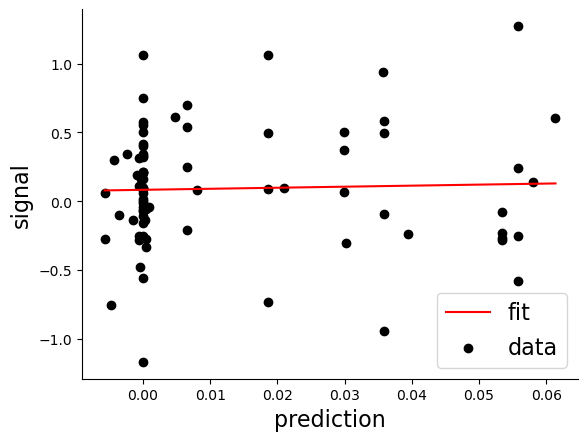

In [6]:
_, _, simulated_signal = simulate_bold_response(SOA=12, evoked_response=[10], noise=0.5)
reg = LinearRegression().fit(simulated_signal['raw'].values.reshape([-1, 1]), simulated_signal['noisy'])
pred_range = np.array([min(simulated_signal['raw']), max(simulated_signal['raw'])])
fit_range = reg.predict(pred_range.reshape(-1, 1)).reshape(-1, 1)

fig, ax = plt.subplots()
ax.plot(pred_range, fit_range, 'r-', label='fit')
ax.scatter(simulated_signal['raw'], simulated_signal['noisy'], color='k', label='data')
ax.legend(fontsize=16)
ax.set_xlabel('prediction', fontsize=16)
ax.set_ylabel('signal', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('simulated_signal_weak_effect.svg')

## Linear regression in two dimensions

[make_first_level_design_matrix] A 'modulation' column was found in the given events data and is used.


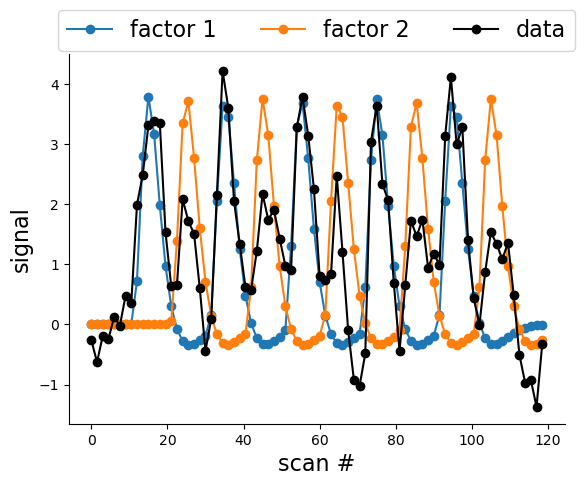

In [7]:
_, dmtx, simulated_signal = simulate_bold_response(SOA=10, evoked_response=[600, 600], weights=[1, 0.5], noise=0.5)

fig, ax = plt.subplots()
ax.plot(dmtx['tone_0'], 'o-', label='factor 1')
ax.plot(dmtx['tone_1'], 'o-', label='factor 2')
ax.plot(simulated_signal['noisy'], 'ko-', label='data')
ax.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.set_xlabel('scan #', fontsize=16)
ax.set_ylabel('signal', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('simulated_signal_two_factors.svg')

/home/fmeyniel/miniforge3/envs/basic/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/fmeyniel/miniforge3/envs/basic/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/fmeyniel/miniforge3/envs/basic/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/fmeyniel/miniforge3/envs/basic/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/fmeyniel/miniforge3/envs/basic/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have

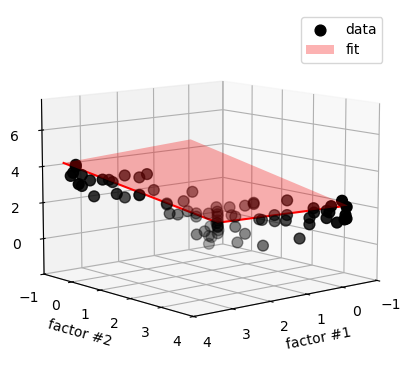

In [8]:
reg = LinearRegression().fit(dmtx.drop(columns='constant'), simulated_signal['noisy'])

orig = reg.predict(np.array([[0, 0]]))[0]
effect_factor_1 = reg.predict(np.array([[dmtx['tone_0'].max()*1.1, 0]]))[0]
effect_factor_2 = reg.predict(np.array([[0, dmtx['tone_1'].max()*1.1]]))[0]

# Create a new figure and add a 3D axis
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')

# Make the scatter plots
# ax.scatter(dmtx['tone_0'], dmtx['tone_1'], simulated_signal['noisy'], c=range(len(simulated_signal)), cmap='viridis', s=60)
ax.scatter(dmtx['tone_0'], dmtx['tone_1'], simulated_signal['noisy'], s=60, c='k', label='data')

# plot two red vectors that define the regression plane
ax.plot([0, dmtx['tone_0'].max()*1.1], [0, 0], [orig, effect_factor_1], 'r')
ax.plot([0, 0], [0, dmtx['tone_1'].max()*1.1], [orig, effect_factor_2], 'r')

# Create a semi-transparent plane defined by the two red vectors
u = [0, dmtx['tone_0'].max()*1.1]
v = [0, dmtx['tone_1'].max()*1.1]
u_grid, v_grid = np.meshgrid(u, v)

# Points on the plane: orig + u*vec1 + v*vec2
x_plane = u_grid
y_plane = v_grid
z_plane = orig + u_grid * (reg.predict(np.array([[1, 0]]))[0] - orig) + v_grid * (reg.predict(np.array([[0, 1]]))[0] - orig)

# Plot the surface with transparency
ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.3, color='red', label='fit')


# Label the axes
ax.set_xlabel('factor #1')
ax.set_xlim([np.floor(np.min([dmtx['tone_0'].min(), dmtx['tone_1'].min()])),
            np.ceil(np.max([dmtx['tone_0'].max(), dmtx['tone_1'].max()]))])
ax.set_ylabel('factor #2')
ax.set_ylim([np.floor(np.min([dmtx['tone_0'].min(), dmtx['tone_1'].min()])),
            np.ceil(np.max([dmtx['tone_0'].max(), dmtx['tone_1'].max()]))])
ax.set_zlabel('signal')
ax.legend()
ax.view_init(elev=10, azim=50)  # 30° elevation, 45° azimuth
plt.tight_layout()
fig.savefig('regression_two_factors.svg')

## Exercice #1  Investigate the effect of timing of stimuli on the measured fMRI signal

This code plots the fMRI signal. The following parameter can be adjusted (on the sliders):
 - The SOA (time between two tones)
- The differential response elicited by the two tones (how much bigger is the response to the second tone, compared to the first)
 - The noise level.

**Q1.1.** Describe the temporal features of the fMRI signal compared to the neural signal.

**Q1.2.** For noise level = 0, and Response ratio = 2, vary the SOA and estimate visually what is the shorter SOA for which you can still distinguish the responses to the two tones.

**Q1.3.** Now increase the noise level. Can you still distinguish the responses to the two tones?


In [9]:
style = {"description_width": "200px"}
layout = {'width': '400px'}

@interact(SOA=widgets.FloatSlider(min=0, max=10, value=10, step=1,
                                       style=style, layout=layout,
                                       description="SOA"), 
          differential_response=widgets.FloatSlider(min=1, max=2, value=1, 
                                   style=style, layout=layout,
                                   description="Response ratio"),
          noise=widgets.FloatSlider(min=0., max=1, value=0., step=0.1,
                                      style=style, layout=layout,
                                      description="Noise level"))
def plot_signal(SOA, differential_response, noise):
    events, simulation, signal = simulate_bold_response(
        SOA=SOA,
        evoked_response=[500, 500*differential_response],
        noise=noise)

    # neural signal
    plt.figure()
    plt.subplot(2,1,1)
    plt.stem(events['onset'][0::2], events['modulation'][0::2], 'k', label='tone 1')
    plt.stem(events['onset'][1::2], events['modulation'][1::2], 'r', label='tone 2')
    plt.xlim([simulation.index[0], simulation.index[-1]])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.6))
    plt.ylabel('neural signal')

    # fMRI signal
    plt.subplot(2,1,2)
    plt.plot(signal['raw'], label='prediction')
    plt.plot(signal['noisy'], label='data')
    plt.xlim([simulation.index[0], simulation.index[-1]])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.6))
    plt.xlabel('Time (s)')
    plt.ylabel('fMRI signal')
    plt.tight_layout()

interactive(children=(FloatSlider(value=10.0, description='SOA', layout=Layout(width='400px'), max=10.0, step=…

## Exercise #2  fMRI noise is auto-correlated noise

The code simulates different responses to the same event.
It highlights two samples taken before the event, on scan #10 and #11,
and plots the values on scan #11 as a function of the values on scan #10.
- The number of stimulated responses can be increased.
- The noise autocorrelation can be increased.

 **Q2.1.** Increase the number of simulations to 100. Is the noise autocorrelation due to the event?

**Q2.2.** Explain why strong noise autocorrelation is expected in fMRI.
 
 **Q2.3.** Set the noise autocorrelation to 0. Why does the signal still look noisy?

In [10]:
style = {"description_width": "200px"}
layout = {'width': '400px'}

@interact(n_sim=widgets.IntSlider(min=1, max=100, value=1, step=1,
                                      style=style, layout=layout,
                                      description="num. of simulations"),
         ar_noise=widgets.FloatSlider(min=0., max=1, value=0.5, step=0.1,
                                      style=style, layout=layout,
                                      description="Noise autocorrelation"))
def simulation(n_sim, ar_noise):
    simulated_time_series = []
    for _ in range(n_sim):
        events, dmtx, signal = simulate_bold_response(
            SOA=18,
            evoked_response=[600],
            noise=2,
            ar_noise=ar_noise)
        clear_output(wait=True)
        simulated_time_series.append(signal['noisy'])
    simulated_time_series = np.vstack(simulated_time_series)

    plt.subplot(2, 1, 1)
    plt.plot(simulated_time_series.T, '.-', lw=2)
    plt.plot(signal['raw'].values, 'k.-', lw=2, label='predicted signal')
    plt.plot([10, 11], simulated_time_series[:, 10:12].T, 'k.-', alpha=0.5, lw=3, ms=15)
    plt.xlim([0, 25])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.6))
    plt.xlabel('scan #')
    plt.ylabel('fMRI signal')

    plt.subplot(2, 1, 2)
    plt.plot(simulated_time_series[:, 10],
             simulated_time_series[:, 11], '.')
    plt.axis('square')
    plt.xlabel("signal on scan #10")
    plt.ylabel("signal on scan #11")
    plt.tight_layout()

interactive(children=(IntSlider(value=1, description='num. of simulations', layout=Layout(width='400px'), min=…

## Exercice #3: Effect of Noise on Inference

The goal of this exercise is to test whether noise correlation impacts significance levels associated with regression estimates.
We compare two methods:
- Ordinary Least Squares (OLS), which assumes errors are independently and identically distributed
- Auto Regressive (AR), which assumes errors are autocorrelated

The error $\epsilon$, also called residuals, corresponds to the part of the signal not captured by the prediction:

$y = X \beta + \epsilon$

**Q3.1.** Change the noise level and compare, between OLS and AR models, the impact on estimated regression coefficients and significance levels.

**Q3.2.** Set the noise autocorrelation to 0 and repeat the previous question. What do you observe?

**Q3.3.** Based on your observations in **Q1** and **Q2**, do you think it is better to use an AR model or an OLS model to estimate significance levels at the subject-level?

**Q3.4.** Same question as **Q3** but now for group-level analysis where only subject-level regression coefficients are analyzed.


In [11]:
noise_models = ['ols', 'ar1'] 
style = {"description_width": "200px"}
layout = {'width': '400px'}

@interact(noise=widgets.FloatSlider(min=0., max=10, value=1, step=1,
                                      style=style, layout=layout,
                                      description="Noise level"),
        ar_noise=widgets.FloatSlider(min=0., max=1, value=0.5, step=0.1,
                                      style=style, layout=layout,
                                      description="Noise auto correlation"))
def simulate_inference(noise, ar_noise):
    # get design matrix and simulate signal
    events, dmtx, signal = simulate_bold_response(
        SOA=12, 
        evoked_response=[600, 800], 
        noise=noise,
        ar_noise=ar_noise)
    clear_output(wait=True)

    # plot signal and prediction
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(signal, '.-')
    plt.legend(['predicted', 'observed'], loc='upper left', bbox_to_anchor=(1, 0.6))
    plt.xlabel('Time (s)')
    plt.ylabel('fMRI signal')
    plt.subplot(2, 1, 2)
    plt.plot(signal['raw'], signal['noisy'], '.')
    plt.axis('square')
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.tight_layout()

    for noise_model in noise_models:
        # estimate GLM
        labels, estimates = run_glm(signal.values,
                                    dmtx.values,
                                    noise_model=noise_model)

        # compute contrast
        contrast = compute_contrast(labels, estimates,
                                    np.array([1 if 'tone_0'==reg_name else 0
                                              for reg_name in dmtx.columns]),
                                    stat_type='t')

        print(f"Estimate with {noise_model}: "
              f"Regression coef.: {contrast.effect_size()[1]:.2f}, "
              f"T-value: {contrast.stat()[1]:.3}, "
              f"P-value: {contrast.p_value()[1]:.3}")

interactive(children=(FloatSlider(value=1.0, description='Noise level', layout=Layout(width='400px'), max=10.0…